In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import librosa


In [2]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
import soundfile as sf
import sounddevice as sd
from sklearn.mixture import *

In [3]:
wavFile="6313.mp3"

In [4]:
wav,_ = librosa.load(wavFile,sr=16000)

In [5]:
sf.write('6313.wav', wav, 16000, 'PCM_16')


In [6]:
segLen = 3
frameRate = 50
numMix = 128


In [7]:
short_term_energy = librosa.feature.rms(wav, hop_length= 16000//frameRate).T

C:\Users\Tejashaarav S\AppData\Local\Temp\ipykernel_15704\2048908954.py:1: FutureWarning: Pass y=[ 0.00058063  0.00078114  0.00084714 ... -0.01748307 -0.01611081
 -0.00883927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  short_term_energy = librosa.feature.rms(wav, hop_length= 16000//frameRate).T


In [8]:
def voice_activity_detection(wav, frameRate):
    short_term_energy = librosa.feature.rms(wav, hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(short_term_energy,97.5) + 9*np.percentile(short_term_energy,2.5))
    return(short_term_energy>thresh).astype(bool)

In [9]:
vad=voice_activity_detection(wav,frameRate)

C:\Users\Tejashaarav S\AppData\Local\Temp\ipykernel_15704\1575048720.py:2: FutureWarning: Pass y=[ 0.00058063  0.00078114  0.00084714 ... -0.01748307 -0.01611081
 -0.00883927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  short_term_energy = librosa.feature.rms(wav, hop_length=int(16000/frameRate)).T


In [11]:
vad = np.reshape(vad,(len(vad),))

In [10]:
mfcc = librosa.feature.mfcc(wav, sr = 16000, n_mfcc=20,hop_length=int(16000/frameRate) ).T


C:\Users\Tejashaarav S\AppData\Local\Temp\ipykernel_15704\1044717952.py:1: FutureWarning: Pass y=[ 0.00058063  0.00078114  0.00084714 ... -0.01748307 -0.01611081
 -0.00883927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(wav, sr = 16000, n_mfcc=20,hop_length=int(16000/frameRate) ).T


In [12]:
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:]

In [13]:
n_components = np.arange(1, 25)

In [14]:
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

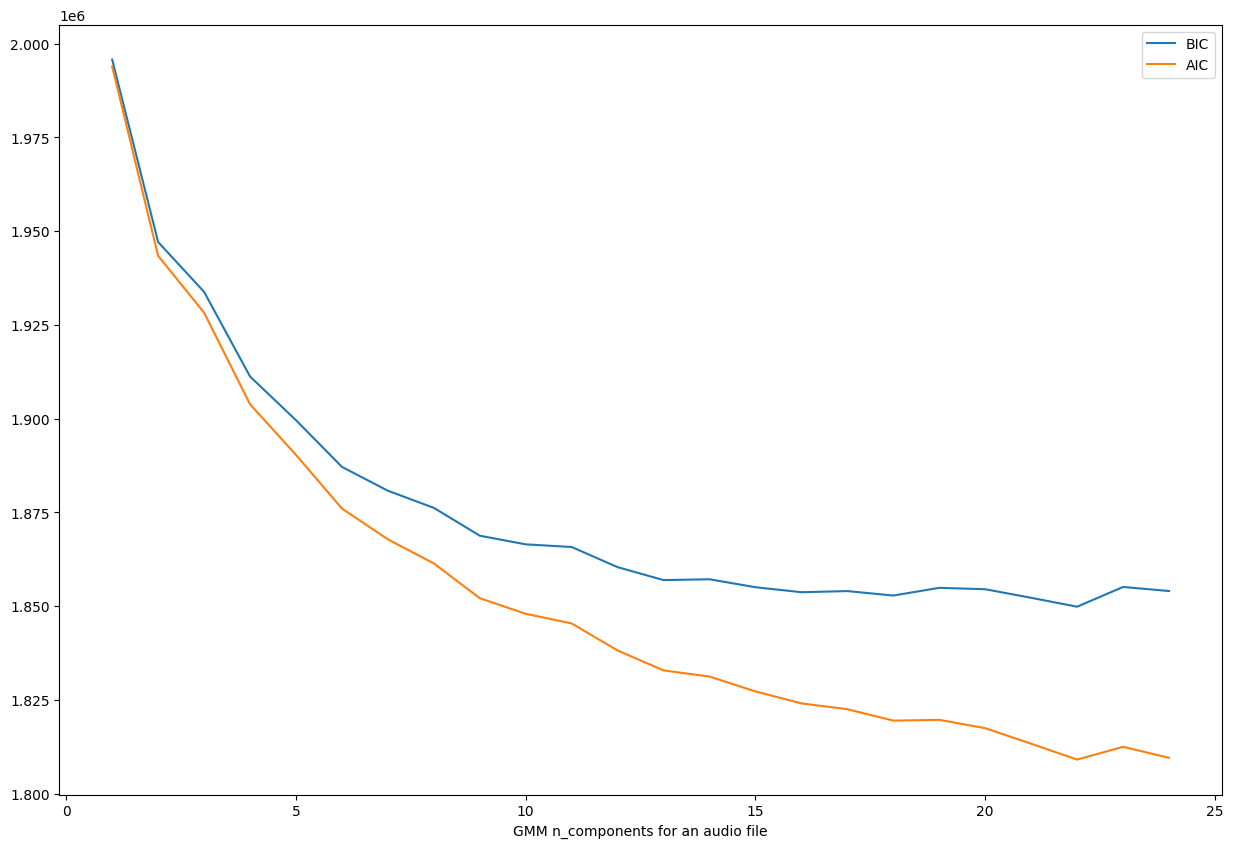

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

In [17]:
type(models[0])

sklearn.mixture._gaussian_mixture.GaussianMixture

In [18]:
def GMMtrain(wav, frameRate, segLen, vad, numMix, mfcc):
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])

    return np.asarray(segLikes)
    

    

In [19]:
clusterset = GMMtrain(wav, frameRate, segLen, vad, numMix, mfcc)


In [20]:
type(clusterset)

numpy.ndarray

In [21]:
clusterset

array([[1.89762448e-05, 7.31872397e-05, 1.90756508e-12, ...,
        3.98216744e-06, 3.27189237e-05, 8.63775728e-05],
       [4.07615143e-07, 4.12236270e-10, 5.73829972e-21, ...,
        1.07804374e-06, 1.61499654e-07, 9.65533575e-04],
       [2.03069511e-02, 6.52588081e-03, 9.21733964e-05, ...,
        2.48498089e-02, 4.96557285e-07, 4.89978825e-03],
       ...,
       [6.78728973e-06, 6.42007880e-09, 6.75793439e-13, ...,
        6.16404442e-09, 2.16501450e-05, 5.06927832e-04],
       [1.77074082e-04, 1.18784976e-12, 6.70110030e-27, ...,
        9.96240503e-15, 9.41032885e-05, 1.86310780e-06],
       [1.57294488e-04, 7.35096125e-19, 9.49993568e-26, ...,
        2.34526862e-12, 7.95836068e-06, 3.95580308e-04]])

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)

In [23]:
X_normalized = normalize(X_scaled)


In [24]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_normalized)

In [25]:
def segment_to_frame(clust, segLen, frameRate, numframes):
    frameclust = np.zeros(numframes)
    for clustI in range(len(clust)-1):
        frameclust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameclust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numframes-(clustI+1)*segLen*frameRate)
    return frameclust

In [26]:
frameClust = segment_to_frame(clust, segLen, frameRate, mfcc.shape[0])


In [27]:
frameClust

array([1., 1., 1., ..., 0., 0., 0.])

In [29]:
def speakerdiarisation(hyp, framerate, wavFile):
    audioname = []
    starttime = []
    end_time = []
    speaker_label = []
    change_points = np.where(hyp[:-1] != hyp[1:])[0]
    if  change_points[0] != 0 and hyp[0] != -1:
        change_points = np.concatenate(([0], change_points))
    speakerlabels = []
    for spkrHomoSegI in range(len(change_points)):
        speakerlabels.append(hyp[change_points[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(speakerlabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((change_points[spkrI]+1)/float(frameRate))
            end_time.append((change_points[spkrI+1]-change_points[spkrI])/float(frameRate))
            speaker_label.append("Speaker "+str(int(spkr)))
    if speakerlabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(change_points[-1]/float(frameRate))
        end_time.append((len(hyp) - change_points[-1])/float(frameRate))
        speaker_label.append("Speaker "+str(int(speakerlabels[-1])))
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":end_time,"speakerlabel":speaker_label})
    spdatafinal=pd.DataFrame(columns=['Audio','speaker #','Start','End'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal

In [30]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisation(pass1hyp, frameRate, wavFile)

In [31]:
spkdf["duration"]=spkdf.EndTime-spkdf.StartTime

In [33]:
spkdf.rename(columns = {'SpeakerLabel':'speaker#'}, inplace = True)




In [35]:
spkdf.rename(columns = {'StartTime':'start'}, inplace = True)

In [36]:
spkdf.rename(columns = {'EndTime':'end'}, inplace = True)

In [38]:
spkdf.rename(columns = {'TimeSeconds':'duration'}, inplace = True)

In [39]:
spkdf

,Audio,speaker#,start,end,duration
0,6313.wav,Speaker 1,1.50,8.28,6.78
1,6313.wav,Speaker 0,8.28,156.88,148.60
2,6313.wav,Speaker 1,156.88,162.28,5.40
3,6313.wav,Speaker 0,162.28,216.84,54.56
4,6313.wav,Speaker 1,216.84,221.32,4.48
5,6313.wav,Speaker 0,221.32,236.98,15.66
6,6313.wav,Speaker 1,236.98,241.22,4.24
7,6313.wav,Speaker 0,241.22,310.68,69.46
8,6313.wav,Speaker 1,310.68,315.20,4.52
9,6313.wav,Speaker 0,315.20,393.58,78.38
